In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=834c9681e7533b142e2a0714364553d482878320aedf9ebfd63f4c3e680e1f0f
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch torchvision torchmetrics

In [3]:
!pip uninstall -y torch-fidelity torchmetrics
!pip install torchmetrics[image] torch-fidelity

Found existing installation: torchmetrics 1.6.1
Uninstalling torchmetrics-1.6.1:
  Successfully uninstalled torchmetrics-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.5 MB/s eta 0:00:00a 0:00:01


In [4]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Initialize Frechet Inception Distance (FID)
try:
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True)
    print("✅ FID metric initialized successfully!")
except Exception as e:
    print("❌ FID metric initialization failed:", e)

# Initialize Inception Score (IS)
try:
    is_metric = InceptionScore()
    print("✅ Inception Score metric initialized successfully!")
except Exception as e:
    print("❌ Inception Score metric initialization failed:", e)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 276MB/s]


✅ FID metric initialized successfully!


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


✅ Inception Score metric initialized successfully!


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd
import torch.nn.functional as F

# For MedMNIST dataset (using PathMNIST)
from medmnist import INFO, PathMNIST

# For evaluation metrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
image_size = 28       # MedMNIST images are 28x28 pixels
nz = 100              # Dimension of the latent vector (input noise)
num_epochs = 50
lr = 0.0002
beta1 = 0.5         # For Adam optimizer
data_flag = 'pathmnist'  # Using PathMNIST subset
img_channels = 3    # Use 3 channels (RGB)

######################################
#       Model Definitions            #
######################################

class Generator(nn.Module):
    def __init__(self, nz, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, feature_g * 7 * 7),
            nn.BatchNorm1d(feature_g * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_g, 7, 7)),
            nn.ConvTranspose2d(feature_g, feature_g // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g // 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g // 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )
        
    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(feature_d * 2 * 7 * 7, 1)
        )
        
    def forward(self, x):
        return self.net(x)

######################################
#       Data Loading                 #
######################################

def get_medmnist_dataloader(data_flag='pathmnist', batch_size=64):
    # Download and load the MedMNIST dataset using the training split.
    train_dataset = PathMNIST(
        split='train',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]),
        download=True
    )
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

######################################
#       Evaluation Functions         #
######################################

def prepare_images_for_eval(fake):
    """
    Convert generated images from [-1, 1] to [0, 1] and upsample to 299x299 for evaluation.
    Return in float format (don't convert to uint8 here, as some metrics might need float).
    """
    fake = (fake + 1) / 2.0  # Scale to [0, 1]
    fake = torch.nn.functional.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)
    return fake

def evaluate_generator(generator, device, nz, dataloader, num_samples=5000, eval_batch_size=64):
    generator.eval()
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    inception_metric = InceptionScore().to(device)
    
    # First, process real images from your dataset
    for real_batch, _ in dataloader:  # Assuming dataloader returns (images, labels)
        if len(real_batch) < eval_batch_size:
            continue  # Skip incomplete batches
            
        real_batch = real_batch.to(device)
        real_processed = prepare_images_for_eval(real_batch)  # Ensure same preprocessing for real images
        fid_metric.update(real_processed, real=True)
        
        # Stop after collecting enough real samples
        if fid_metric.real_features_num_samples >= num_samples:
            break
    
    # Then, generate and process fake images
    total_batches = num_samples // eval_batch_size
    for i in range(total_batches):
        noise = torch.randn(eval_batch_size, nz, device=device)
        with torch.no_grad():
            fake = generator(noise)
        fake = prepare_images_for_eval(fake)
        fid_metric.update(fake, real=False)
        # Convert to uint8 format for inception metric
        inception_metric.update((fake * 255).byte())
        
    fid_score = fid_metric.compute()
    inception_score_mean, inception_score_std = inception_metric.compute()
    
    generator.train()
    return fid_score.item(), inception_score_mean.item(), inception_score_std.item()

######################################
#       Training Functions           #
######################################

# ---- LSGAN Training Function ----
def train_lsgan(generator, discriminator, dataloader, num_epochs, device, writer, log_interval=100):
    criterion = nn.MSELoss()
    optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    fixed_noise = torch.randn(64, nz, device=device)
    step = 0

    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(dataloader):
            real = data.to(device)
            b_size = real.size(0)
            label_real = torch.ones(b_size, 1, device=device)
            label_fake = torch.zeros(b_size, 1, device=device)

            # Train Discriminator
            discriminator.zero_grad()
            output_real = discriminator(real)
            loss_real = criterion(output_real, label_real)
            noise = torch.randn(b_size, nz, device=device)
            fake = generator(noise)
            output_fake = discriminator(fake.detach())
            loss_fake = criterion(output_fake, label_fake)
            lossD = 0.5 * (loss_real + loss_fake)
            lossD.backward()
            optimizerD.step()

            # Train Generator
            generator.zero_grad()
            label_gen = torch.ones(b_size, 1, device=device)
            output = discriminator(fake)
            lossG = criterion(output, label_gen)
            lossG.backward()
            optimizerG.step()

            if i % log_interval == 0:
                writer.add_scalar("LSGAN/Discriminator_loss", lossD.item(), step)
                writer.add_scalar("LSGAN/Generator_loss", lossG.item(), step)
                step += 1

        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake_images, normalize=True)
        writer.add_image("LSGAN/Generated_images", grid, epoch)
        print(f"LSGAN Epoch [{epoch+1}/{num_epochs}] LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")

# ---- WGAN Training Function ----
def train_wgan(generator, discriminator, dataloader, num_epochs, device, writer, log_interval=100, clip_value=0.01):
    optimizerD = optim.RMSprop(discriminator.parameters(), lr=lr)
    optimizerG = optim.RMSprop(generator.parameters(), lr=lr)
    fixed_noise = torch.randn(64, nz, device=device)
    step = 0
    n_critic = 5

    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(dataloader):
            real = data.to(device)
            b_size = real.size(0)
            # Train discriminator n_critic times
            for _ in range(n_critic):
                discriminator.zero_grad()
                noise = torch.randn(b_size, nz, device=device)
                fake = generator(noise)
                lossD = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
                lossD.backward()
                optimizerD.step()
                for p in discriminator.parameters():
                    p.data.clamp_(-clip_value, clip_value)
            # Train Generator
            generator.zero_grad()
            noise = torch.randn(b_size, nz, device=device)
            fake = generator(noise)
            lossG = -torch.mean(discriminator(fake))
            lossG.backward()
            optimizerG.step()

            if i % log_interval == 0:
                writer.add_scalar("WGAN/Discriminator_loss", lossD.item(), step)
                writer.add_scalar("WGAN/Generator_loss", lossG.item(), step)
                step += 1

        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake_images, normalize=True)
        writer.add_image("WGAN/Generated_images", grid, epoch)
        print(f"WGAN Epoch [{epoch+1}/{num_epochs}] LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")

# ---- WGAN-GP Training Function ----
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_wgan_gp(generator, discriminator, dataloader, num_epochs, device, writer, log_interval=100, lambda_gp=10, n_critic=5):
    optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.9))
    optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.9))
    fixed_noise = torch.randn(64, nz, device=device)
    step = 0

    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(dataloader):
            real = data.to(device)
            b_size = real.size(0)
            # Train discriminator n_critic times
            for _ in range(n_critic):
                discriminator.zero_grad()
                noise = torch.randn(b_size, nz, device=device)
                fake = generator(noise)
                loss_D_real = -torch.mean(discriminator(real))
                loss_D_fake = torch.mean(discriminator(fake))
                gradient_penalty = compute_gradient_penalty(discriminator, real, fake, device)
                lossD = loss_D_real + loss_D_fake + lambda_gp * gradient_penalty
                lossD.backward()
                optimizerD.step()
            # Train Generator
            generator.zero_grad()
            noise = torch.randn(b_size, nz, device=device)
            fake = generator(noise)
            lossG = -torch.mean(discriminator(fake))
            lossG.backward()
            optimizerG.step()

            if i % log_interval == 0:
                writer.add_scalar("WGAN-GP/Discriminator_loss", lossD.item(), step)
                writer.add_scalar("WGAN-GP/Generator_loss", lossG.item(), step)
                step += 1

        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake_images, normalize=True)
        writer.add_image("WGAN-GP/Generated_images", grid, epoch)
        print(f"WGAN-GP Epoch [{epoch+1}/{num_epochs}] LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")


In [10]:
# Create a SummaryWriter for LSGAN logs
writer_lsgan = SummaryWriter(log_dir="runs/lsgan_experiment")

# Load data
dataloader = get_medmnist_dataloader(data_flag=data_flag, batch_size=batch_size)

# Initialize LSGAN models
generator_lsgan = Generator(nz, img_channels=img_channels).to(device)
discriminator_lsgan = Discriminator(img_channels=img_channels).to(device)

# Train LSGAN
print("Starting LSGAN Training")
train_lsgan(generator_lsgan, discriminator_lsgan, dataloader, num_epochs, device, writer_lsgan)
writer_lsgan.close()

100%|██████████| 206M/206M [00:10<00:00, 19.2MB/s] 


Starting LSGAN Training
LSGAN Epoch [1/50] LossD: 0.1372, LossG: 0.4864
LSGAN Epoch [2/50] LossD: 0.0767, LossG: 0.4514
LSGAN Epoch [3/50] LossD: 0.1554, LossG: 0.1887
LSGAN Epoch [4/50] LossD: 0.0928, LossG: 0.4166
LSGAN Epoch [5/50] LossD: 0.1662, LossG: 1.5083
LSGAN Epoch [6/50] LossD: 0.1867, LossG: 0.1834
LSGAN Epoch [7/50] LossD: 0.0668, LossG: 0.7356
LSGAN Epoch [8/50] LossD: 0.2164, LossG: 0.5276
LSGAN Epoch [9/50] LossD: 0.0415, LossG: 0.6085
LSGAN Epoch [10/50] LossD: 0.0498, LossG: 1.0138
LSGAN Epoch [11/50] LossD: 0.1154, LossG: 0.3679
LSGAN Epoch [12/50] LossD: 0.1938, LossG: 1.7612
LSGAN Epoch [13/50] LossD: 0.0689, LossG: 0.5406
LSGAN Epoch [14/50] LossD: 0.0661, LossG: 0.7003
LSGAN Epoch [15/50] LossD: 0.1523, LossG: 2.2373
LSGAN Epoch [16/50] LossD: 0.0518, LossG: 1.1764
LSGAN Epoch [17/50] LossD: 0.1502, LossG: 0.4878
LSGAN Epoch [18/50] LossD: 0.0521, LossG: 0.5750
LSGAN Epoch [19/50] LossD: 0.0822, LossG: 0.4842
LSGAN Epoch [20/50] LossD: 0.0721, LossG: 1.4066
LSGAN

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ValueError: Expecting image as torch.Tensor with dtype=torch.uint8

LSGAN Evaluation: FID=48.1336, Inception Score: 2.0299 ± 0.0684


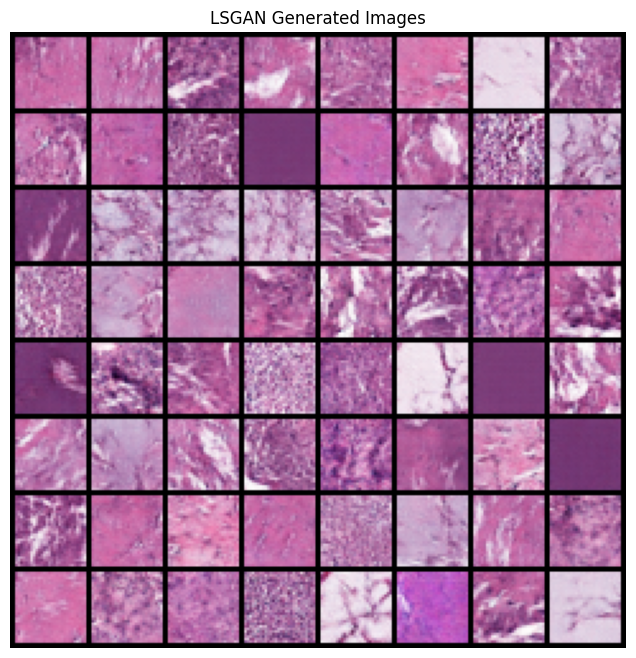

In [14]:
# Evaluate LSGAN generator
fid_lsgan, is_mean_lsgan, is_std_lsgan = evaluate_generator(generator_lsgan, device, nz, dataloader)
print(f"LSGAN Evaluation: FID={fid_lsgan:.4f}, Inception Score: {is_mean_lsgan:.4f} ± {is_std_lsgan:.4f}")

# Display a grid of generated images
import matplotlib.pyplot as plt
fixed_noise = torch.randn(64, nz, device=device)
with torch.no_grad():
    fake_images = generator_lsgan(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake_images, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("LSGAN Generated Images")
plt.axis("off")
plt.show()

In [6]:
# Create a SummaryWriter for WGAN logs
writer_wgan = SummaryWriter(log_dir="runs/wgan_experiment")

# Load data (if not already loaded, you can reuse the same dataloader)
dataloader = get_medmnist_dataloader(data_flag=data_flag, batch_size=batch_size)

# Initialize WGAN models
generator_wgan = Generator(nz, img_channels=img_channels).to(device)
discriminator_wgan = Discriminator(img_channels=img_channels).to(device)

# Train WGAN
print("Starting WGAN Training")
train_wgan(generator_wgan, discriminator_wgan, dataloader, num_epochs, device, writer_wgan)
writer_wgan.close()

100%|██████████| 206M/206M [02:47<00:00, 1.23MB/s] 


Starting WGAN Training
WGAN Epoch [1/50] LossD: -0.1018, LossG: 0.1982
WGAN Epoch [2/50] LossD: -0.1141, LossG: 0.1691
WGAN Epoch [3/50] LossD: -0.1162, LossG: 0.0288
WGAN Epoch [4/50] LossD: -0.1078, LossG: 0.0618
WGAN Epoch [5/50] LossD: -0.1027, LossG: -0.0847
WGAN Epoch [6/50] LossD: 0.0282, LossG: 0.0020
WGAN Epoch [7/50] LossD: -0.0280, LossG: 0.0113
WGAN Epoch [8/50] LossD: -0.0707, LossG: 0.0774
WGAN Epoch [9/50] LossD: -0.0170, LossG: -0.0372
WGAN Epoch [10/50] LossD: -0.0150, LossG: -0.0706
WGAN Epoch [11/50] LossD: -0.0107, LossG: 0.0113
WGAN Epoch [12/50] LossD: -0.0082, LossG: 0.0555
WGAN Epoch [13/50] LossD: -0.0460, LossG: -0.0304
WGAN Epoch [14/50] LossD: -0.0865, LossG: -0.1861
WGAN Epoch [15/50] LossD: -0.0832, LossG: -0.0798
WGAN Epoch [16/50] LossD: -0.0171, LossG: -0.0581
WGAN Epoch [17/50] LossD: -0.0256, LossG: -0.1325
WGAN Epoch [18/50] LossD: -0.0137, LossG: -0.0045
WGAN Epoch [19/50] LossD: -0.0273, LossG: -0.0410
WGAN Epoch [20/50] LossD: -0.0061, LossG: -0.0

In [8]:
import matplotlib.pyplot as plt

WGAN Evaluation: FID=133.2617, Inception Score: 1.7240 ± 0.0277


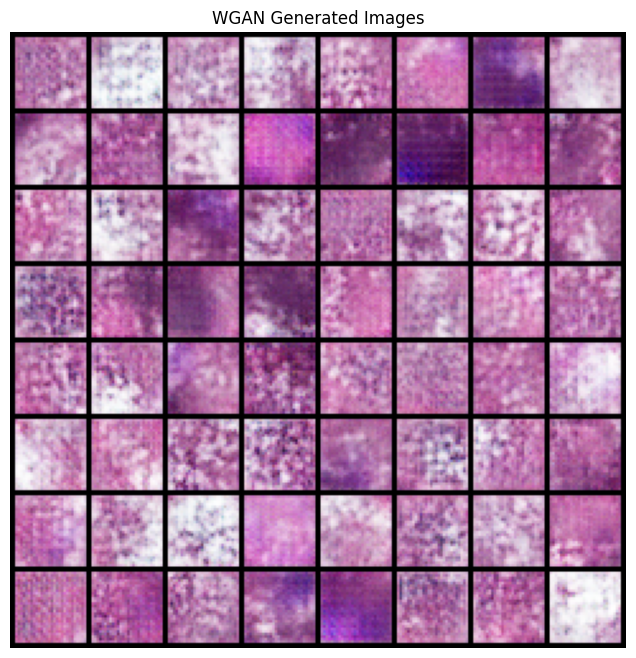

In [9]:
# Evaluate WGAN generator
fid_wgan, is_mean_wgan, is_std_wgan = evaluate_generator(generator_wgan, device, nz, dataloader)
print(f"WGAN Evaluation: FID={fid_wgan:.4f}, Inception Score: {is_mean_wgan:.4f} ± {is_std_wgan:.4f}")

# Display a grid of generated images
fixed_noise = torch.randn(64, nz, device=device)
with torch.no_grad():
    fake_images = generator_wgan(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake_images, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("WGAN Generated Images")
plt.axis("off")
plt.show()

In [6]:
# Create a SummaryWriter for WGAN-GP logs
writer_wgan_gp = SummaryWriter(log_dir="runs/wgan_gp_experiment")

# Load data (reuse dataloader if desired)
dataloader = get_medmnist_dataloader(data_flag=data_flag, batch_size=batch_size)

# Initialize WGAN-GP models
generator_wgan_gp = Generator(nz, img_channels=img_channels).to(device)
discriminator_wgan_gp = Discriminator(img_channels=img_channels).to(device)

# Train WGAN-GP
print("Starting WGAN-GP Training")
train_wgan_gp(generator_wgan_gp, discriminator_wgan_gp, dataloader, num_epochs, device, writer_wgan_gp)
writer_wgan_gp.close()

100%|██████████| 206M/206M [00:12<00:00, 15.9MB/s] 


Starting WGAN-GP Training


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


WGAN-GP Epoch [1/50] LossD: 778.5554, LossG: -195.8313
WGAN-GP Epoch [2/50] LossD: -2063.2075, LossG: -416.9977
WGAN-GP Epoch [3/50] LossD: 4849.9121, LossG: -406.3527
WGAN-GP Epoch [4/50] LossD: 6595.4648, LossG: -627.5887
WGAN-GP Epoch [5/50] LossD: -6554.1177, LossG: -354.6134
WGAN-GP Epoch [6/50] LossD: -10543.6514, LossG: -350.9588
WGAN-GP Epoch [7/50] LossD: 26767.9023, LossG: -206.5435
WGAN-GP Epoch [8/50] LossD: 61.7133, LossG: -468.6949
WGAN-GP Epoch [9/50] LossD: -21.2807, LossG: -115.0157
WGAN-GP Epoch [10/50] LossD: -16.1478, LossG: 77.8827
WGAN-GP Epoch [11/50] LossD: 21.5171, LossG: 259.2172
WGAN-GP Epoch [12/50] LossD: 608.2611, LossG: 260.3007
WGAN-GP Epoch [13/50] LossD: -372.2419, LossG: 418.9526
WGAN-GP Epoch [14/50] LossD: -1196.6312, LossG: 513.9669
WGAN-GP Epoch [15/50] LossD: -3759.8557, LossG: 837.3674
WGAN-GP Epoch [16/50] LossD: 69873.4766, LossG: 698.8168
WGAN-GP Epoch [17/50] LossD: -8994.0762, LossG: 896.2234
WGAN-GP Epoch [18/50] LossD: -13944.3857, LossG:

In [8]:
import matplotlib.pyplot as plt

WGAN-GP Evaluation: FID=414.3542, Inception Score: 1.0049 ± 0.0003


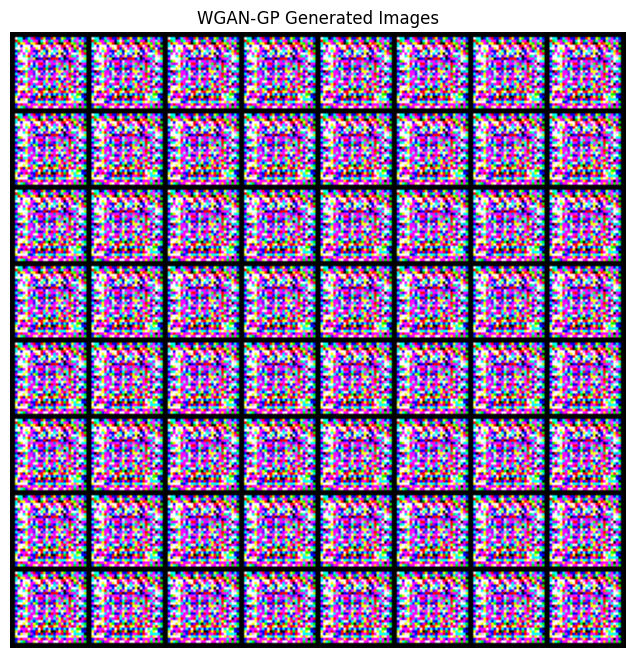

In [9]:
# Evaluate WGAN-GP generator
fid_wgan_gp, is_mean_wgan_gp, is_std_wgan_gp = evaluate_generator(generator_wgan_gp, device, nz, dataloader)
print(f"WGAN-GP Evaluation: FID={fid_wgan_gp:.4f}, Inception Score: {is_mean_wgan_gp:.4f} ± {is_std_wgan_gp:.4f}")

# Display a grid of generated images
fixed_noise = torch.randn(64, nz, device=device)
with torch.no_grad():
    fake_images = generator_wgan_gp(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake_images, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("WGAN-GP Generated Images")
plt.axis("off")
plt.show()